<img src="https://raw.githubusercontent.com/autonomousvision/navsim/main/assets/navsim_transparent.png" alt="drawing" width="800"/>

# NAVSIM Visualization Tutorial

This notebook will introduce some basic plots to visualize the driving scenes in NAVSIM. All plots are created with `matplotlib` and are easy to customize for your application.

## Table of Contents
1. [Config](#config)
2. [Birds-Eye-View](#bev)
3. [Cameras](#camera)
4. [Creating custom plots](#custom)
5. [Creating GIFs](#gifs)

## Config <a name="config"></a>

NAVSIM offers two types of plots: 
- Birds-Eye-View (BEV) plots or 
- Camera plots. 

The LiDAR sensor can be visualized either in BEV or in camera images. All plots have a global configuration in [`navsim/visualization/config.py`](https://github.com/autonomousvision/navsim/blob/main/navsim/navsim/visualization/config.py). In this Python file, you can configure all colors or dimensions. The LiDAR point cloud can be colored in any colormap, showing the distance to the ego vehicle or the height of each point. In this tutorial, we first instantiate a `SceneFilter` and `SceneLoader` from the mini split.

In [1]:
import os
from pathlib import Path

os.environ['HOME'] = '/root/workdir'
os.environ['NUPLAN_MAP_VERSION'] = 'nuplan-maps-v1.0'
os.environ['NUPLAN_MAPS_ROOT'] = '/root/workdir/NAVSIM/dataset/maps'
os.environ['NAVSIM_EXP_ROOT'] = '/root/workdir/NAVSIM/exp'
os.environ['NAVSIM_DEVKIT_ROOT'] = '/root/workdir/NAVSIM/navsim'
os.environ['OPENSCENE_DATA_ROOT'] = '/root/workdir/NAVSIM/dataset'

In [2]:
import os
from pathlib import Path

import hydra
from hydra.utils import instantiate
import numpy as np
import matplotlib.pyplot as plt

from navsim.common.dataloader import SceneLoader
from navsim.common.dataclasses import SceneFilter, SensorConfig

SPLIT = "test"  # ["mini", "test", "trainval"]
FILTER = "all_scenes"

hydra.initialize(config_path="../navsim/planning/script/config/common/train_test_split/scene_filter")
cfg = hydra.compose(config_name=FILTER)
scene_filter: SceneFilter = instantiate(cfg)
openscene_data_root = Path(os.getenv("OPENSCENE_DATA_ROOT"))

scene_loader = SceneLoader(
    openscene_data_root / f"navsim_logs/{SPLIT}",
    openscene_data_root / f"sensor_blobs/{SPLIT}",
    scene_filter,
    sensor_config=SensorConfig.build_all_sensors(),
)

/tmp/ipykernel_49603/3635110668.py:15: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  hydra.initialize(config_path="../navsim/planning/script/config/common/train_test_split/scene_filter")
Loading logs: 100%|██████████| 147/147 [00:09<00:00, 15.74it/s]


## Birds-Eye-View <a name="bev"></a>

The Birds-Eye-View (BEV) visualization in NAVSIM is useful for overviewing the map, bounding-box annotations, or the LiDAR point cloud. In standard setting, the BEV plot includes a 64m $\times$ 64m frame centered at the rear axle of the ego vehicle (excluding LiDAR for simplicity). First, we take a random token and load a scene to visualize.

In [3]:
token = np.random.choice(scene_loader.tokens)
scene = scene_loader.get_scene_from_token(token)

The function `plot_bev_frame` takes a `Scene` and index of the step to visualize (history or future). 

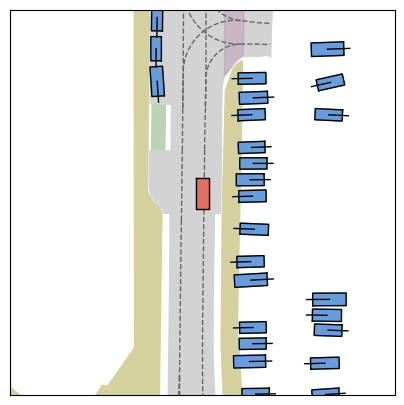

In [9]:
from navsim.visualization.plots import plot_bev_frame

frame_idx = scene.scene_metadata.num_history_frames - 1 # current frame
fig, ax = plot_bev_frame(scene, frame_idx)
plt.show()

The function `plot_bev_with_agent` visualizes the trajectory of an <span style="color:#DE7061">agent</span> in comparison to the <span style="color:#59a14f">human vehicle operator</span> at the current frame. This notebook shows an example of the naive `ConstantVelocityAgent`:

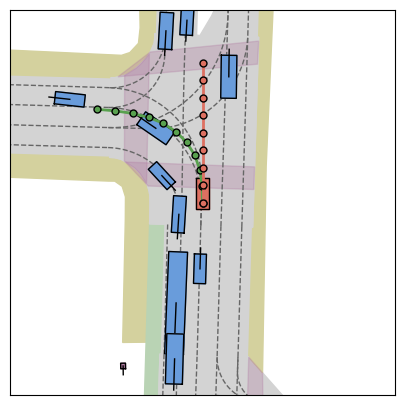

In [30]:
from navsim.visualization.plots import plot_bev_with_agent
from navsim.agents.constant_velocity_agent import ConstantVelocityAgent

token = np.random.choice(scene_loader.tokens)
scene = scene_loader.get_scene_from_token(token)

agent = ConstantVelocityAgent()
fig, ax = plot_bev_with_agent(scene, agent)
plt.show()

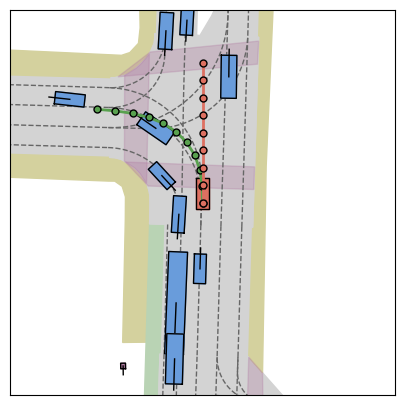

In [31]:
agent = ConstantVelocityAgent()
fig, ax = plot_bev_with_agent(scene, agent)

plt.savefig("cv_agent.jpg", dpi=300)
plt.show()

## Cameras <a name="bev"></a>

The agents in NAVSIM have access to eight cameras surrounding the vehicle. The function `plot_cameras_frame` shows the cameras in a 3 $\times$ 3 grid with cameras in each direction of the ego-vehicle and the BEV plot in the center. 

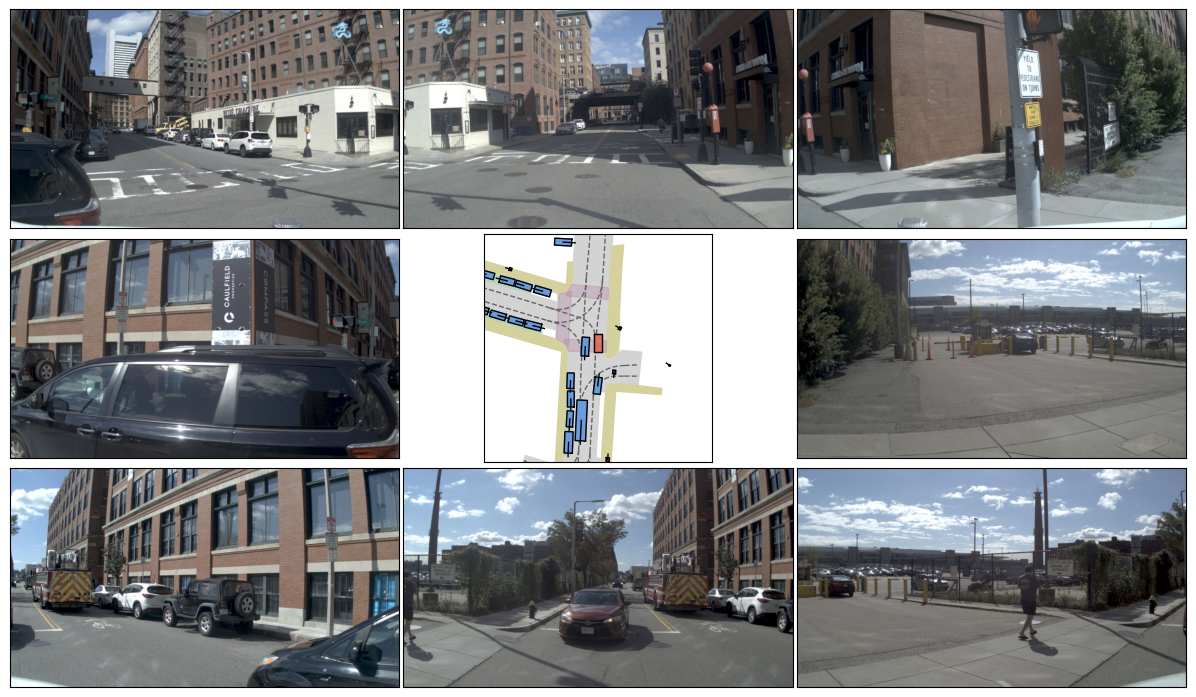

In [15]:
from navsim.visualization.plots import plot_cameras_frame

fig, ax = plot_cameras_frame(scene, frame_idx)
plt.show()

With `plot_cameras_frame_with_annotations`, you can visualize the bounding-box annotations in the camera images.

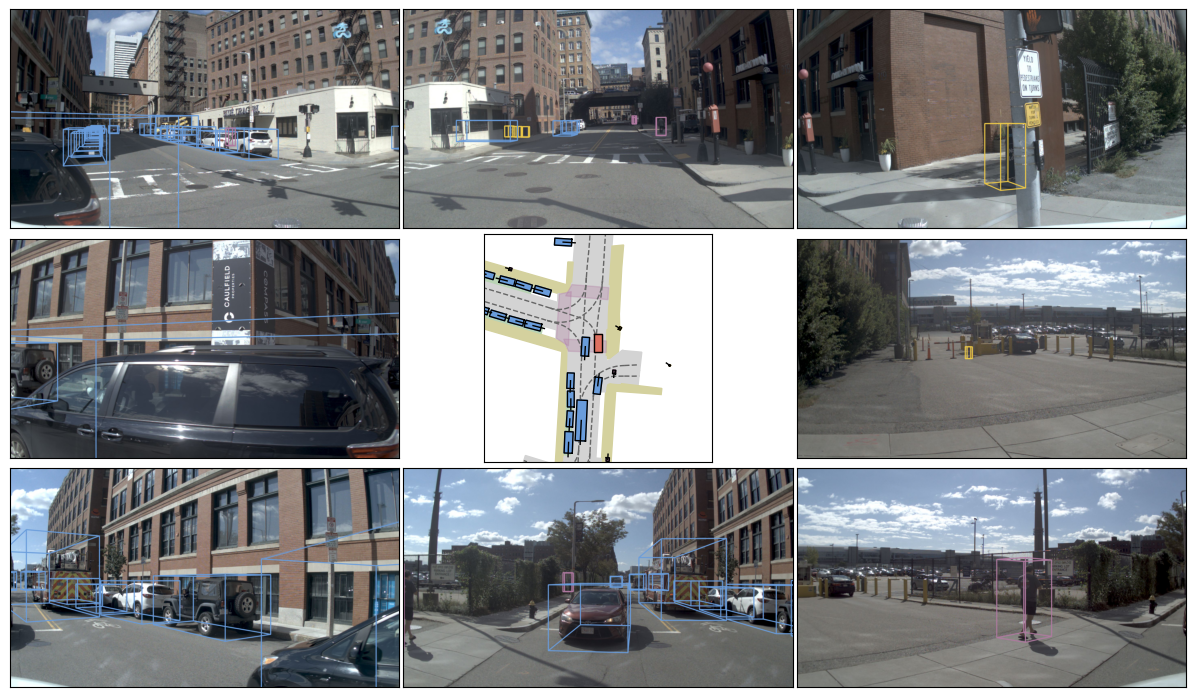

In [16]:
from navsim.visualization.plots import plot_cameras_frame_with_annotations

fig, ax = plot_cameras_frame_with_annotations(scene, frame_idx)

plt.savefig("cameras.jpg", dpi=300)
plt.show()

With `plot_cameras_frame_with_lidar`, you can visualize the LiDAR point cloud in the camera images.

In [ ]:
from navsim.visualization.plots import plot_cameras_frame_with_lidar

fig, ax = plot_cameras_frame_with_lidar(scene, frame_idx)
plt.show()

## Creating custom plots <a name="custom"></a>

The plots in NAVSIM use `matplotlib` and either add elements to a `plt.Axes` object or return the full `plt.Figure`. Functions in [`navsim/visualization/`](https://github.com/autonomousvision/navsim/blob/main/navsim/navsim/visualization) can be re-used to create custom plots. In this example, we create a plot for the bounding-box annotations and the LiDAR point cloud.

In [ ]:
from navsim.visualization.plots import configure_bev_ax
from navsim.visualization.bev import add_annotations_to_bev_ax, add_lidar_to_bev_ax


fig, ax = plt.subplots(1, 1, figsize=(6, 6))

ax.set_title("Custom plot")

add_annotations_to_bev_ax(ax, scene.frames[frame_idx].annotations)
add_lidar_to_bev_ax(ax, scene.frames[frame_idx].lidar)

# configures frame to BEV view
configure_bev_ax(ax)

plt.show()

## Creating GIFs <a name="gifs"></a>

You can transform frame-wise plots into short animated GIFs. Give any function to `frame_plot_to_gif`, which takes a `Scene` and `frame_idx` as input (ie. `plot_cameras_frame_with_annotations`).

In [ ]:
from navsim.visualization.plots import frame_plot_to_gif

frame_indices = [idx for idx in range(len(scene.frames))]  # all frames in scene
file_name = f"./gifs/{token}.gif"
images = frame_plot_to_gif(file_name, plot_cameras_frame_with_annotations, scene, frame_indices)

In [5]:
from navsim.visualization.plots import frame_plot_to_gif
import cv2
from torchvision import transforms

token_2 = np.random.choice(scene_loader.tokens)
scene_2 = scene_loader.get_scene_from_token(token_2)
frame_idx_2 = scene_2.scene_metadata.num_history_frames - 1

/root/anaconda3/envs/navsim/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


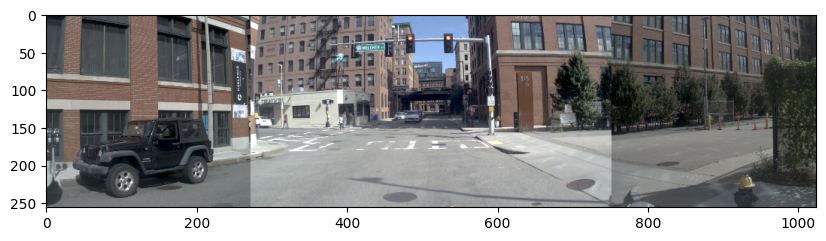

In [6]:
frame = scene_2.frames[frame_idx_2]
cameras = frame.cameras

l0 = cameras.cam_l0.image[28:-28, 416:-416]
f0 = cameras.cam_f0.image[28:-28]
r0 = cameras.cam_r0.image[28:-28, 416:-416]

l2 = cameras.cam_l2.image[28:-28, 832:]
b0 = cameras.cam_b0.image[28:-28]
r2 = cameras.cam_r2.image[28:-28, 0: -832]

# stitch l0, f0, r0 images
plt.figure(figsize=(10, 2.5)) 

stitched_image = np.concatenate([l0, f0, r0], axis=1)
resized_image = cv2.resize(stitched_image, (1024, 256))
plt.imshow(resized_image)
# tensor_image = transforms.ToTensor()(resized_image)
plt.savefig("front_view.jpg", dpi=300)

# stitched_back_image = np.concatenate([r2, b0, l2], axis=1)
# stitched_back_image = np.fliplr(stitched_back_image)
# resized_back_image = cv2.resize(stitched_back_image, (1024, 256))
# tensor_back_image = transforms.ToTensor()(resized_back_image)

# plt.savefig("back_view.jpg", dpi=300)
# plt.show()